In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(n_workers=2)

client

Client Scheduler: tcp://127.0.0.1:65494 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 17.18 GB


In [3]:
from src.parameters import ANIMALS as animals
from loren_frank_data_processing.position import get_trial_time, get_position_dataframe
epoch_key = ('bon', 3, 2)

time = get_trial_time(epoch_key, animals)
position_df = get_position_dataframe(
    epoch_key, animals, skip_linearization=True)

new_index = pd.Index(np.unique(np.concatenate(
    (position_df.index, time))), name='time')
position_df = (position_df
               .reindex(index=new_index)
               .interpolate(method='linear')
               .reindex(index=time))

position_df.loc[position_df.speed < 0, 'speed'] = 0.0

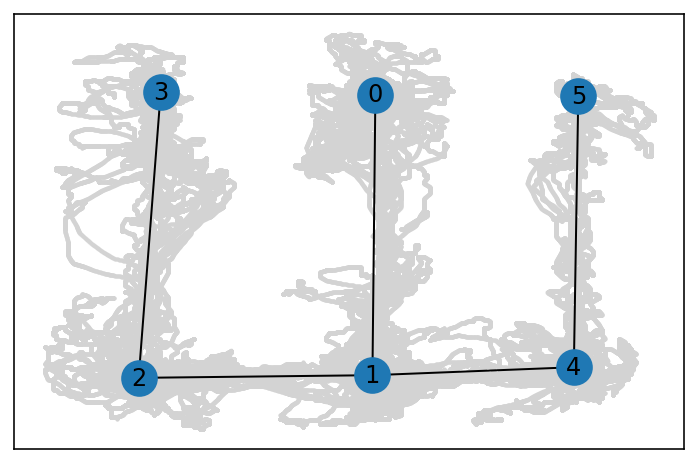

In [74]:
from loren_frank_data_processing.position import make_track_graph as mtg, EDGE_SPACING

from track_linearization import make_track_graph, plot_track_graph, plot_graph_as_1D, get_linearized_position

track_graph, _= mtg(epoch_key, animals)
position = position_df.loc[:, ['x_position', 'y_position']].values
node_positions = [track_graph.nodes[node]["pos"] for node in track_graph.nodes]
edges = list(track_graph.edges)
track_graph = make_track_graph(node_positions, edges)
position = position_df.loc[:, ['x_position', 'y_position']].values
plot_track_graph(track_graph)
plt.scatter(position[:, 0], position[:, 1], color="lightgrey", s=1, alpha=0.3, zorder=0)

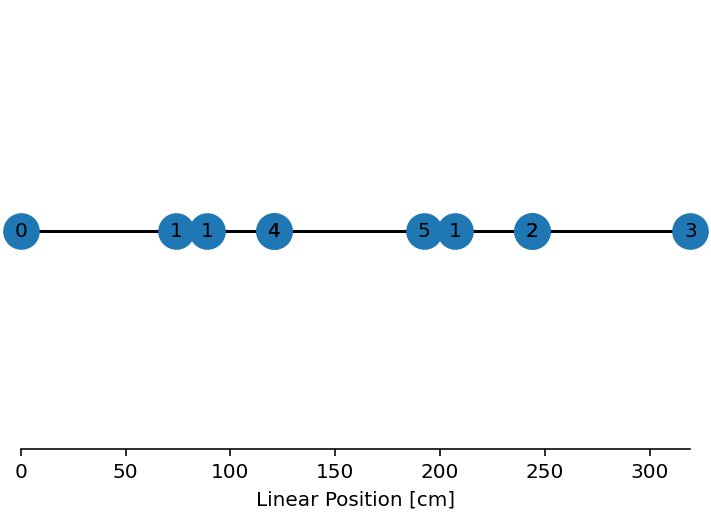

In [32]:
edge_order = [(0, 1), (1, 4), (4, 5), (1, 2), (2, 3)]
edge_spacing = EDGE_SPACING
plot_graph_as_1D(track_graph, edge_order=edge_order, edge_spacing=edge_spacing)

In [33]:
df = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    edge_spacing=edge_spacing,
    edge_order=edge_order,
)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/track_linearization/core.py:49: RuntimeWarning: invalid value encountered in less
  nx[np.where(nx < 0)] = 0.0
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/track_linearization/core.py:50: RuntimeWarning: invalid value encountered in greater
  nx[np.where(nx > 1)] = 1.0
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


In [34]:
df

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,NaN,0.0,NaN,NaN
1,NaN,0.0,NaN,NaN
2,NaN,0.0,NaN,NaN
3,NaN,0.0,NaN,NaN
4,NaN,0.0,NaN,NaN
...,...,...,...,...
1396548,251.219318,3.0,177.040125,81.523756
1396549,251.219318,3.0,177.040125,81.523756
1396550,251.219318,3.0,177.040125,81.523756
1396551,251.219318,3.0,177.040125,81.523756


In [41]:
df3 = get_linearized_position(
    position=position,
    track_graph=track_graph, 
    edge_spacing=edge_spacing,
    edge_order=edge_order,
    use_HMM=False,
)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/track_linearization/core.py:49: RuntimeWarning: invalid value encountered in less
  nx[np.where(nx < 0)] = 0.0
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/track_linearization/core.py:50: RuntimeWarning: invalid value encountered in greater
  nx[np.where(nx > 1)] = 1.0


In [22]:
from loren_frank_data_processing.position import _get_linear_position_hmm, EDGE_ORDER

max_distance_from_well=5
route_euclidean_distance_scaling=1
min_distance_traveled=50
sensor_std_dev=5
diagonal_bias=1E-1
edge_spacing=EDGE_SPACING
edge_order=EDGE_ORDER
position_sampling_frequency=1500


df2 = _get_linear_position_hmm(
        epoch_key, animals, position_df,
        max_distance_from_well, route_euclidean_distance_scaling,
        min_distance_traveled, sensor_std_dev, diagonal_bias,
        edge_order=edge_order, edge_spacing=edge_spacing,
        position_sampling_frequency=position_sampling_frequency)

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/track_segment_classification.py:59: RuntimeWarning: invalid value encountered in less
  nx[np.where(nx < 0)] = 0.0
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/track_segment_classification.py:60: RuntimeWarning: invalid value encountered in greater
  nx[np.where(nx > 1)] = 1.0
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/loren_frank_data_processing/well_traversal_classi

In [23]:
df2

,x_position,y_position,head_direction,speed,linear_distance,projected_x_position,projected_y_position,track_segment_id,arm_name,labeled_segments,from_well,to_well,task,is_correct,turn,linear_position,linear_velocity,linear_speed
time,,,,,,,,,,,,,,,,,,
01:02:08.983700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
01:02:08.984366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
01:02:08.985033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
01:02:08.985700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
01:02:08.986366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Center Arm,1,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01:17:40.015700,178.65,81.45,-1.165905,21.852722,118.000088,177.040125,81.523756,3.0,Left Arm,118,NaN,NaN,NaN,False,NaN,251.219318,-0.028154,0.028154
01:17:40.016366,178.65,81.45,-1.165905,21.852722,118.000088,177.040125,81.523756,3.0,Left Arm,118,NaN,NaN,NaN,False,NaN,251.219318,-0.022523,0.022523
01:17:40.017033,178.65,81.45,-1.165905,21.852722,118.000088,177.040125,81.523756,3.0,Left Arm,118,NaN,NaN,NaN,False,NaN,251.219318,-0.016892,0.016892


(3790.0, 3800.0)

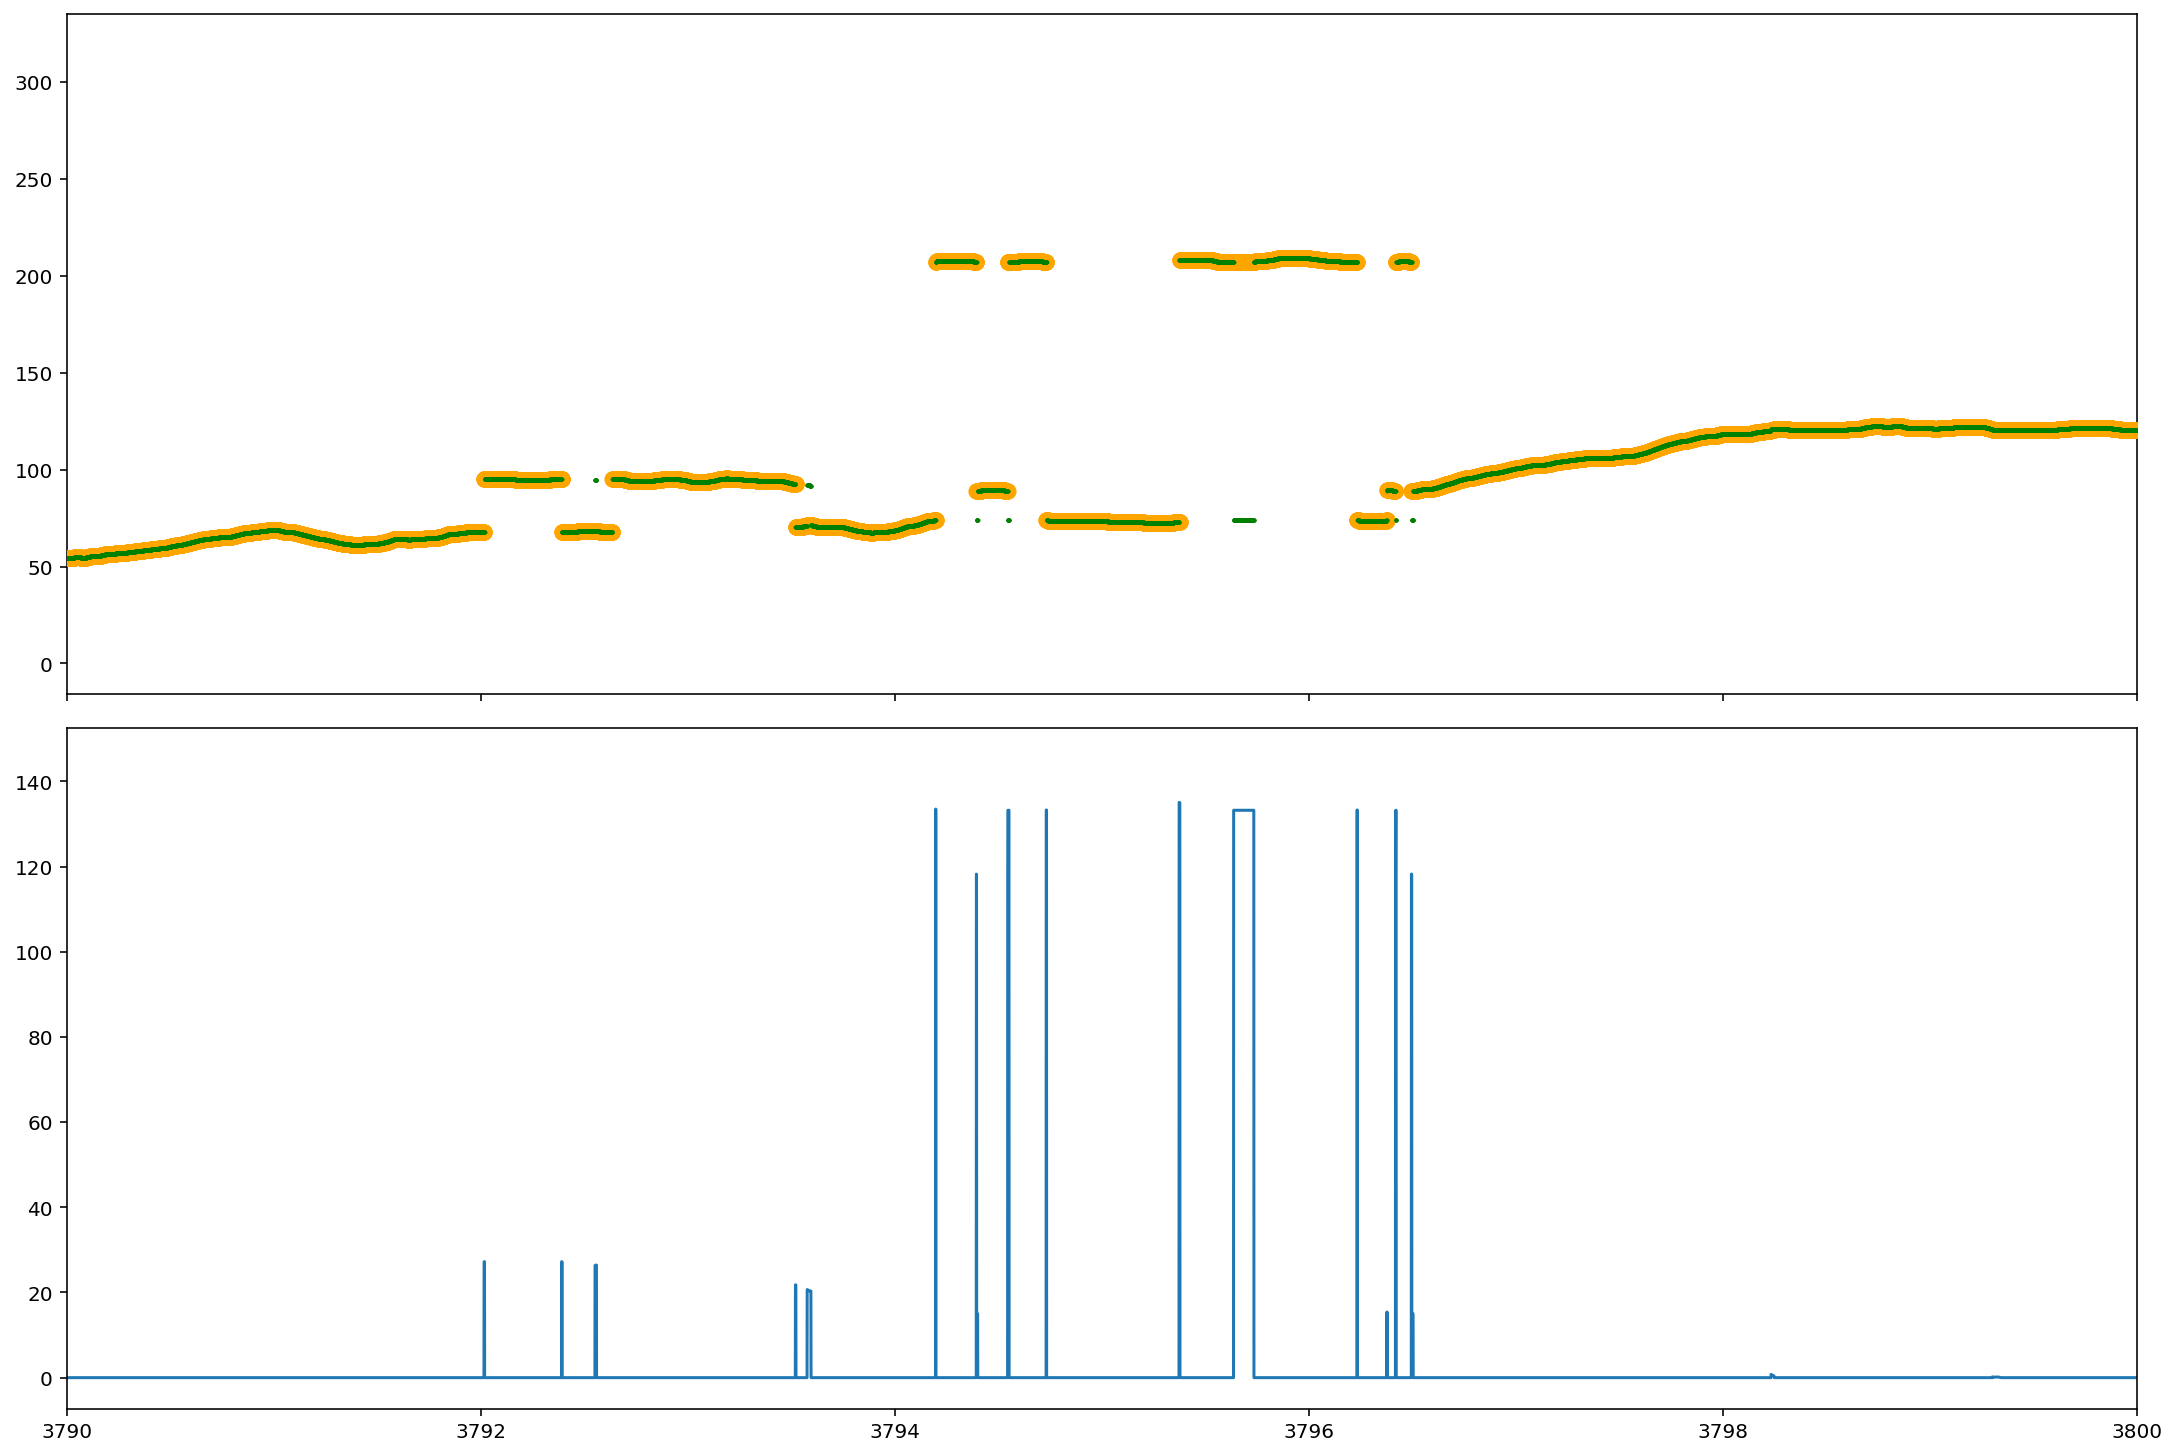

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, constrained_layout=True)

# plt.scatter(df2.index / np.timedelta64(1, 's'), df.linear_position.values)
axes[0].scatter(df2.index / np.timedelta64(1, 's'), df2.linear_position.values, s=50, color="orange", zorder=10)
axes[0].scatter(df2.index / np.timedelta64(1, 's'), df3.linear_position.values, s=1, color="green", zorder=11)

axes[1].plot(df2.index / np.timedelta64(1, 's'), np.abs(df3.linear_position.values - df2.linear_position.values))
plt.xlim((3790, 3800))

(4000.0, 4050.0)

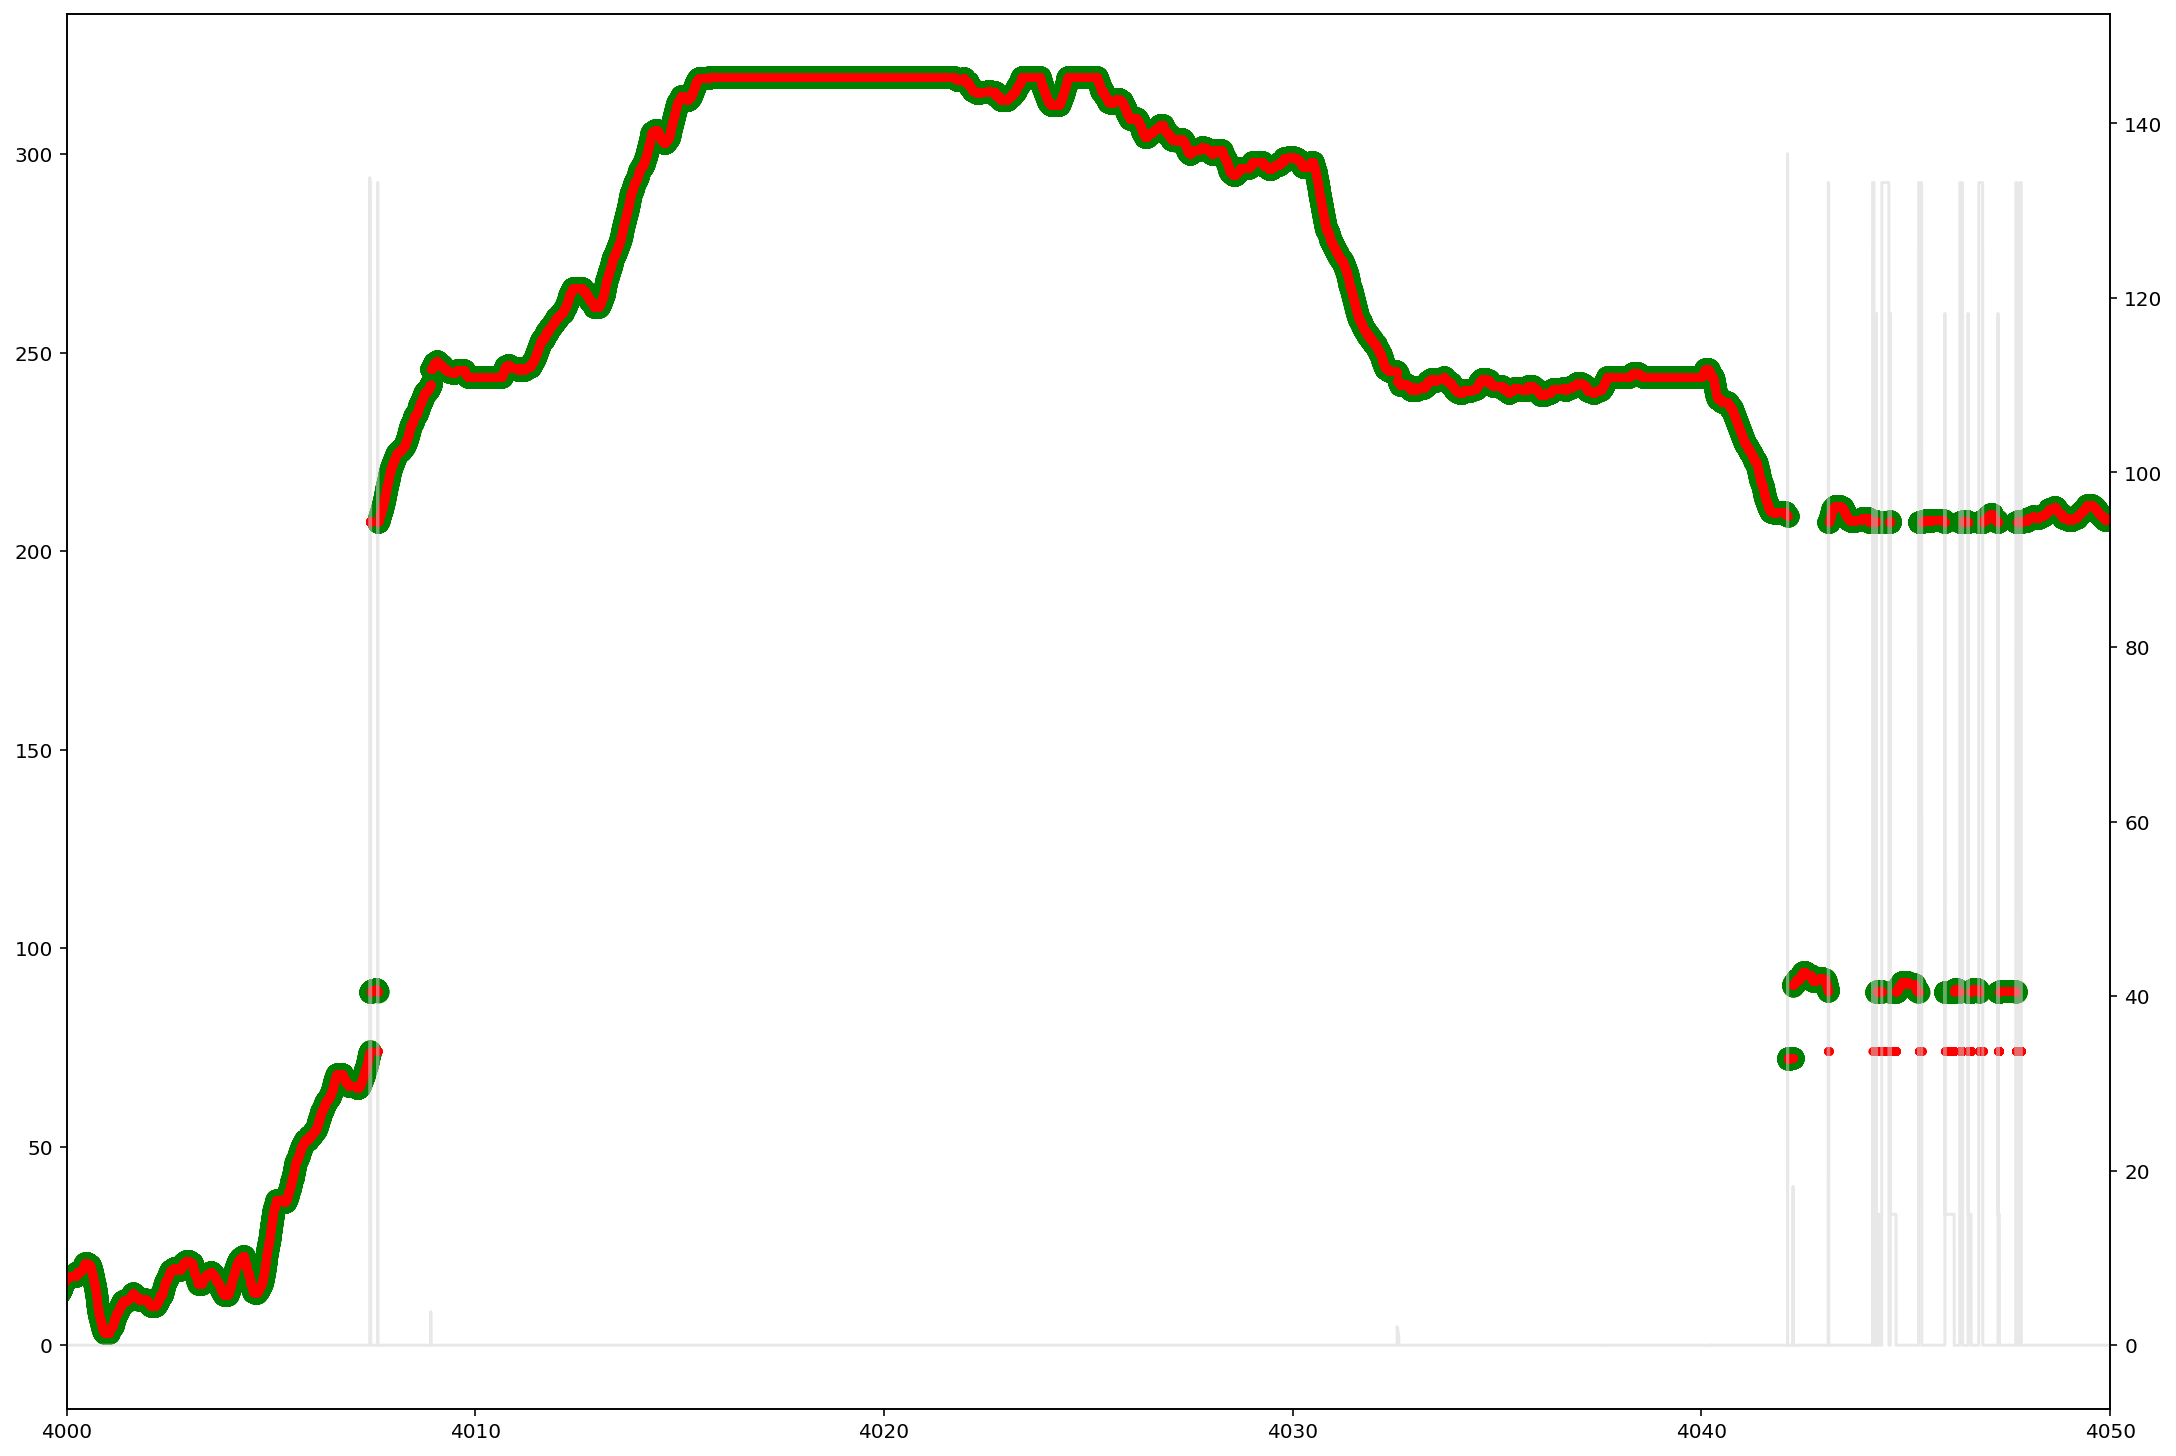

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True, constrained_layout=True)

# plt.scatter(df2.index / np.timedelta64(1, 's'), df.linear_position.values)
ax.scatter(df2.index / np.timedelta64(1, 's'), df2.linear_position.values, s=100, color="green", zorder=10)
ax.scatter(df2.index / np.timedelta64(1, 's'), df3.linear_position.values, s=10, color="red", zorder=11)

ax.twinx().plot(df2.index / np.timedelta64(1, 's'),
                np.abs(df3.linear_position.values - df2.linear_position.values),
                color="lightgrey", alpha=0.5)
plt.xlim((4000, 4050))

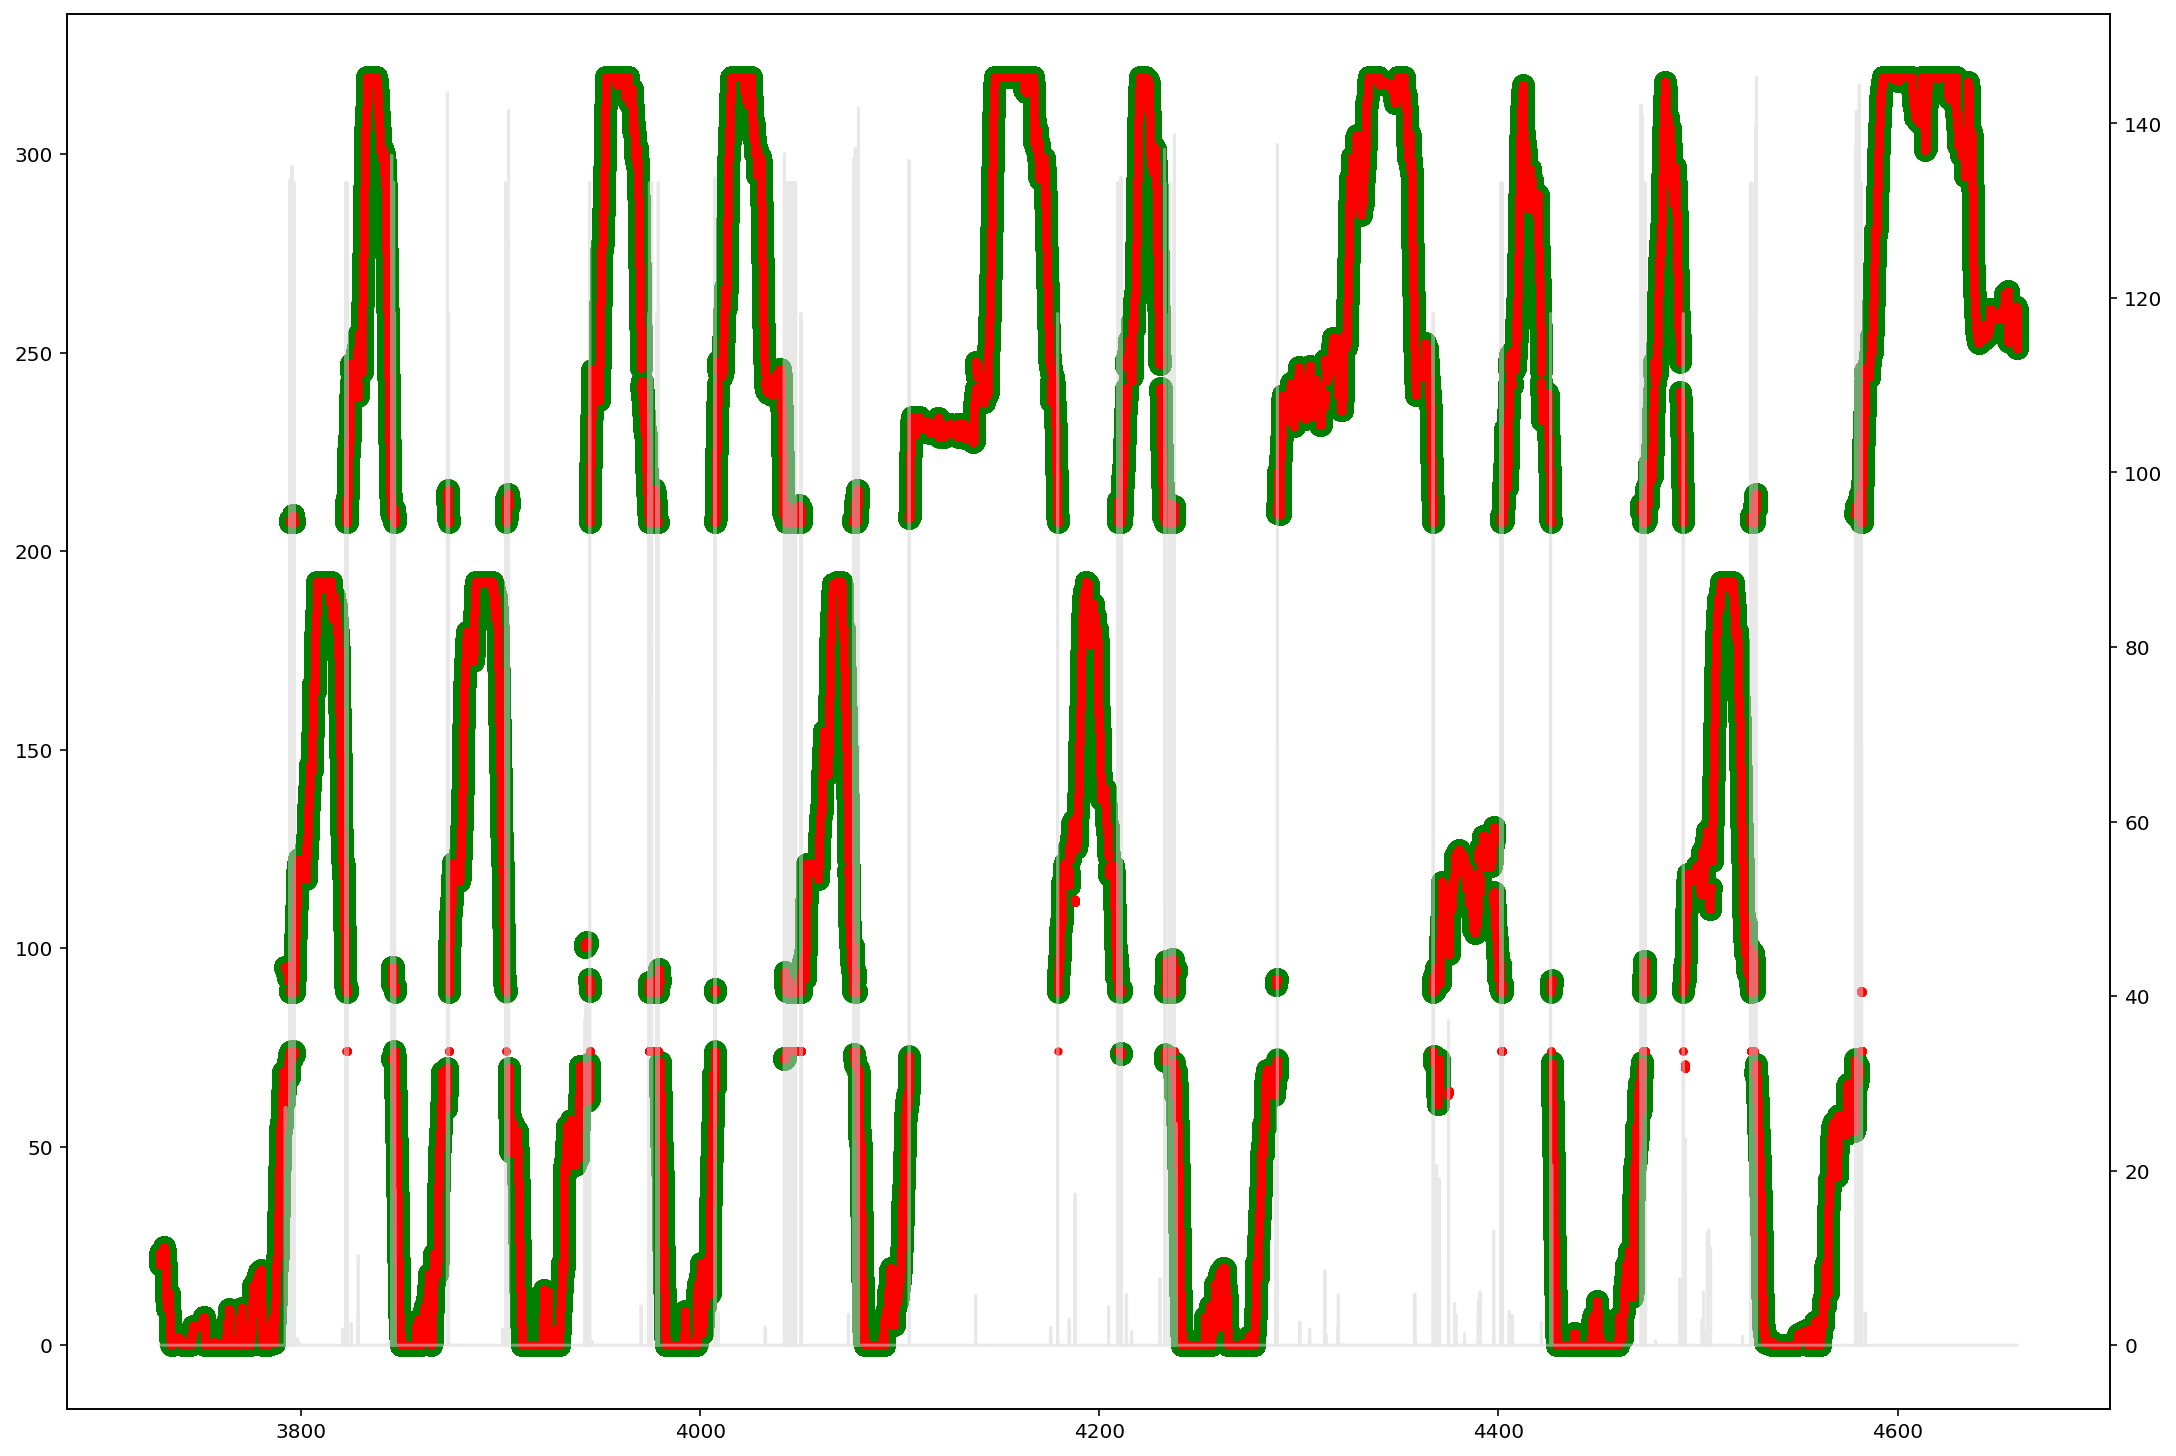

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True, constrained_layout=True)

# plt.scatter(df2.index / np.timedelta64(1, 's'), df.linear_position.values)
ax.scatter(df2.index / np.timedelta64(1, 's'), df2.linear_position.values, s=100, color="green", zorder=10)
ax.scatter(df2.index / np.timedelta64(1, 's'), df3.linear_position.values, s=10, color="red", zorder=11)

ax.twinx().plot(df2.index / np.timedelta64(1, 's'),
                np.abs(df3.linear_position.values - df2.linear_position.values),
                color="lightgrey", alpha=0.5)

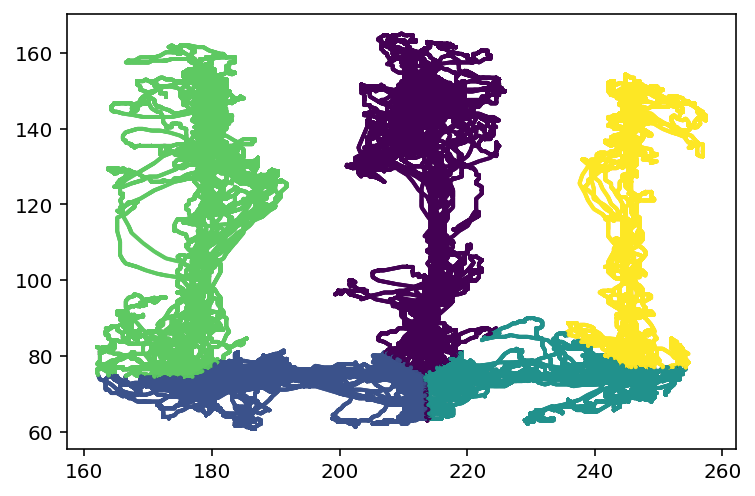

In [77]:
plt.scatter(position[:, 0], position[:, 1], s=1, alpha=0.3, zorder=0, c=df3.track_segment_id)

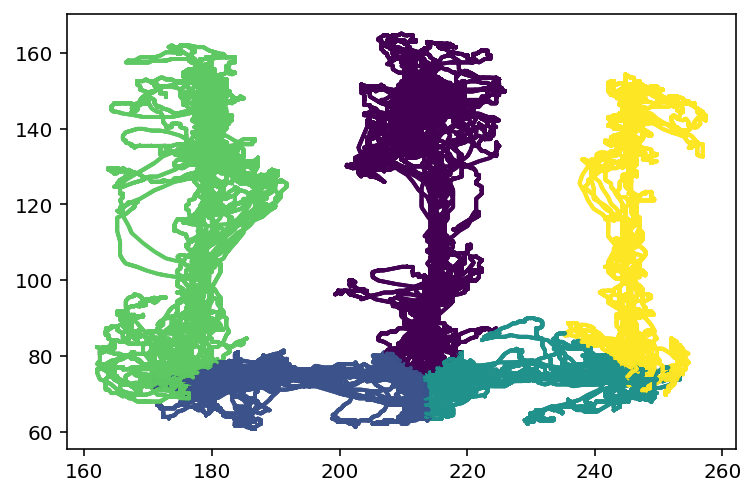

In [78]:
plt.scatter(position[:, 0], position[:, 1], s=1, alpha=0.3, zorder=0, c=df2.track_segment_id)

In [4]:
from loren_frank_data_processing import get_position_dataframe
from src.parameters import ANIMALS

epoch_key = ('bon', 3, 2)

position_info = get_position_dataframe(epoch_key, ANIMALS, use_hmm=True,
                                        max_distance_from_well=5,
                                        route_euclidean_distance_scaling=1,
                                        min_distance_traveled=50,
                                        sensor_std_dev=10,
                                        spacing=30)

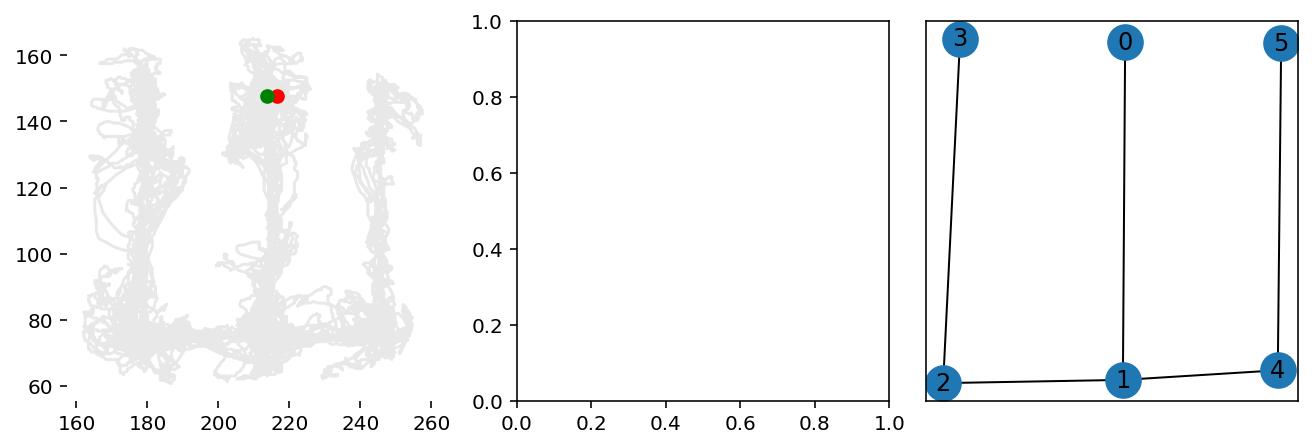

In [51]:
from loren_frank_data_processing.track_segment_classification import (
    get_track_segments_from_graph, project_points_to_segment, plot_track)
from loren_frank_data_processing.position import make_track_graph

import seaborn as sns

def get_projected_track_position(track_graph, track_segment_id, position):
    track_segment_id[np.isnan(track_segment_id)] = 0
    track_segment_id = track_segment_id.astype(int)

    track_segments = get_track_segments_from_graph(track_graph)
    projected_track_position = project_points_to_segment(
        track_segments, position)
    n_time = projected_track_position.shape[0]
    return projected_track_position[(
        np.arange(n_time), track_segment_id)]



track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
position = position_info.loc[:, ['x_position', 'y_position']].values
track_segment_id = position_info.track_segment_id.values
projected_track_position = get_projected_track_position(track_graph, track_segment_id, position)

fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(9, 3))

time_ind = 1000

axes[0].plot(position[:, 0], position[:, 1], color='lightgrey', alpha=0.5, zorder=0)
plot_track(track_graph, ax=axes[2])
axes[0].scatter(position[time_ind, 0], position[time_ind, 1],
                 color='red', zorder=10, s=40)
axes[0].scatter(projected_track_position[time_ind, 0], projected_track_position[time_ind, 1],
                 color='green', zorder=10, s=40)

sns.despine(left=True, bottom=True, ax=axes[0])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'actual_vs_linearized.mp4']


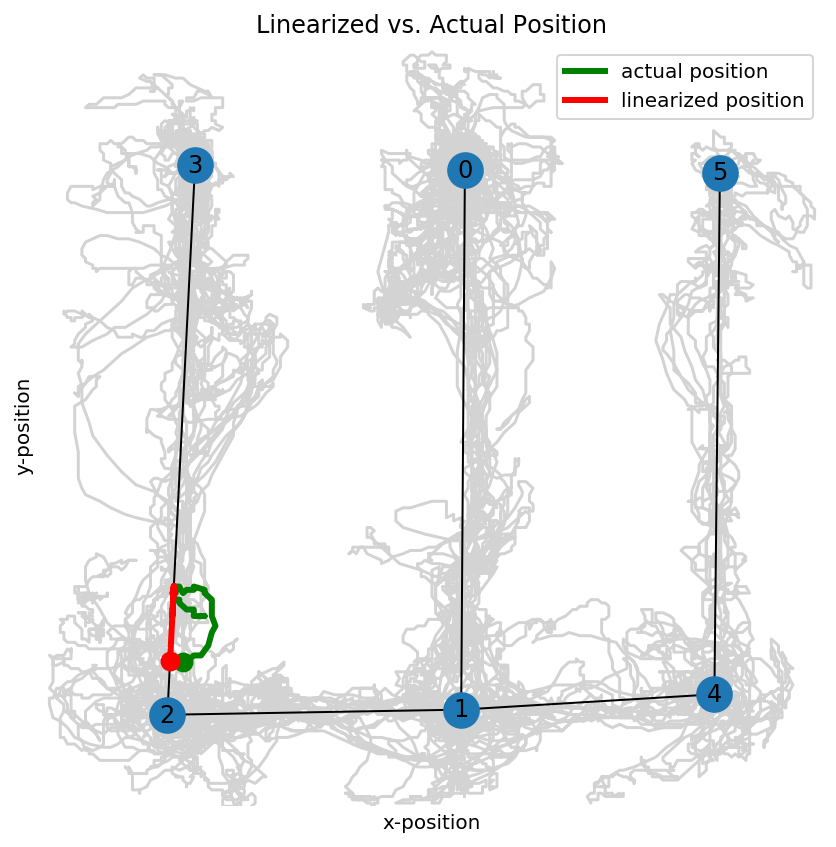

In [56]:
import matplotlib.animation as animation

def plot_linearization(position, projected_track_position, track_graph):
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(position[:, 0], position[:, 1], color='lightgrey', zorder=-10)
    plot_track(track_graph, ax)

    plt.xlim(position[:, 0].min() - 1, position[:, 0].max() + 1)
    plt.ylim(position[:, 1].min() + 1, position[:, 1].max() + 1)
    sns.despine(left=True, bottom=True, ax=ax)
    plt.title('Linearized vs. Actual Position')

    actual_line, = plt.plot([], [], 'g-', label='actual position', linewidth=3, zorder=101)
    actual_head = plt.scatter([], [], s=80, zorder=101, color='g')
    
    predicted_line, = plt.plot([], [], 'r-', label='linearized position', linewidth=3, zorder=102)
    predicted_head = plt.scatter([], [], s=80, zorder=102, color='r')

    plt.legend()


    def _update_line(time_ind):
        start_ind = max(0, time_ind - 33)
        time_slice = slice(start_ind, time_ind)

        actual_line.set_data(position[time_slice, 0], position[time_slice, 1])
        actual_head.set_offsets(position[time_ind])
            
        predicted_line.set_data(projected_track_position[time_slice, 0],
                                projected_track_position[time_slice, 1])
        predicted_head.set_offsets(projected_track_position[time_ind])

        return actual_line, predicted_line

    n_time = projected_track_position.shape[0]
    line_ani = animation.FuncAnimation(fig, _update_line, frames=n_time,
                                       interval=50, blit=True)
    line_ani.save('actual_vs_linearized.mp4', writer=writer)
    
    
plot_linearization(position, projected_track_position, track_graph)

In [57]:
from ipywidgets import Video

Video.from_file('actual_vs_linearized.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\x15\x12\xf3mdat\x0…

In [52]:
position_info.shape

(27901, 17)